# Visualization
In this notebook, we're going to explore what the model we have trained actually learned.
This involves some of the following things:
* **Verify that we actually get better while learning**
* Look at the motifs we learn
* What does the hidden layer tell us about the model

In [21]:
%matplotlib inline

# some always important inputs
import sys
import os
import random
import time
import numpy as np

# the underlying convRBM implementation
sys.path.append(os.path.abspath('../code'))
from convRBM import CRBM
import getData as dataRead

# plotting and data handling
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

# the biopython stuff
import Bio.SeqIO as sio
import Bio.motifs.matrix as mat
from Bio.Alphabet import IUPAC
from Bio.Seq import Seq
from Bio import motifs as mot

## Read in the data and train our model
This part of the notebook trains a convolutional RBM on the DHS data. This may take a lot of time but only once we trained it, will it be possible to do the visualization of what the model learnt.

In [22]:
seqReader = dataRead.FASTAReader()
allSeqs = seqReader.readSequencesFromFile('../data/wgEncodeAwgDnaseUwAg10803UniPk.fa')

#data = [allSeqs[random.randrange(0,len(allSeqs))] for i in range(20000)]
data = allSeqs
train_set, test_set = train_test_split(data, test_size=0.1)
print "Training set size: " + str(len(train_set))
print "Test set size: " + str(len(test_set))

start = time.time()
trainingData = np.array([dataRead.getMatrixFromSeq(t) for t in train_set])
testingData = np.array([dataRead.getMatrixFromSeq(t) for t in test_set])
print "Conversion of test set in (in ms): " + str((time.time()-start)*1000)

Training set size: 154147
Test set size: 17128
ERROR. LETTER N DOES NOT EXIST!
ERROR. LETTER N DOES NOT EXIST!
Conversion of test set in (in ms): 26427.6621342


Data mat shape: (154147, 1, 4, 150)
BatchSize: 10
Num of iterations per epoch: 15414
Compilation of theano function finished in 9.05031704903 seconds
Start training...
Initial Reconstruction Error: 29095.4355469
[Epoch 0] Reconstruction Error: 28039.6269531
[Epoch 1] Reconstruction Error: 25896.4101562
[Epoch 2] Reconstruction Error: 24682.7792969
[Epoch 3] Reconstruction Error: 23333.734375
[Epoch 4] Reconstruction Error: 22223.2578125
[Epoch 5] Reconstruction Error: 22085.2265625
[Epoch 6] Reconstruction Error: 21961.8769531
[Epoch 7] Reconstruction Error: 21834.3730469
[Epoch 8] Reconstruction Error: 21694.3398438
[Epoch 9] Reconstruction Error: 21525.6269531
[Epoch 10] Reconstruction Error: 21314.7773438
[Epoch 11] Reconstruction Error: 21019.6972656
[Epoch 12] Reconstruction Error: 20638.1074219
[Epoch 13] Reconstruction Error: 19983.1210938
[Epoch 14] Reconstruction Error: 19361.5917969
[Epoch 15] Reconstruction Error: 18790.4550781
[Epoch 16] Reconstruction Error: 17531.8359375


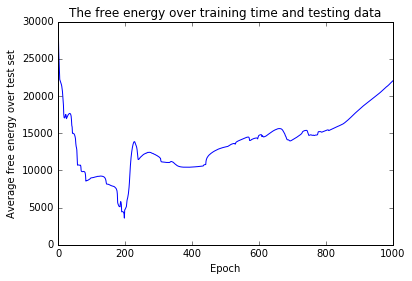

In [23]:
learner = CRBM(9, 20, 0.001, 2)
print "Data mat shape: " + str(trainingData.shape)
start = time.time()
scores = learner.trainMinibatch(trainingData, testingData, 1000, 10, 1)
print "Training of " + str(trainingData.shape[0]) + " performed in: " + str(time.time()-start) + " seconds."
plt.plot(scores)
plt.ylabel('Average free energy over test set')
plt.xlabel('Epoch')
plt.title('The free energy over training time and testing data')
plt.show()

## Time for visualizing things

In [110]:
def getLetterToInt (num):
    if num == 0:
        return 'A'
    elif num == 1:
        return 'C'
    elif num == 2:
        return 'G'
    elif num == 3:
        return 'T'
    else:
        print 'ERROR: Num ' + str(num) + " not a valid char in DNA alphabet"
        return -1

def createMotifFromMatrix (matrix, alphabet=IUPAC.unambiguous_dna):
    assert matrix.shape[0] == 4
    counts = {}
    for row in range(4):
        counts[getLetterToInt(row)] = np.round(matrix[row]).tolist()
    
    motif = mot.Motif(alphabet=alphabet, instances=None, counts=counts)
    return motif
        
        

In [116]:
# first, get the motifs into single 2D matrices within a list
motifs = []
M = learner.motifs.get_value()
for i in range(0, M.shape[0], 2):
    motifs.append(M[i,0])
    
print np.round(motifs[4])
print len(motifs)

[[-30. -59. -49. -45. -44. -49. -48. -45. -61.]
 [  5.  36.  12.  17.  10.  12.  28.  12.  32.]
 [ 22.  22.  13.  33.  17.  25.  29.  14.  22.]
 [-51. -52. -30. -58. -37. -42. -64. -35. -47.]]
20


In [29]:
count = 0
for m in motifs:
    motif = createMotifFromMatrix(m)
    motif.weblogo('motifs/learnedMotif_'+str(count)+'.png', format='PNG')
    count += 1


In [126]:
t = motifs[4]
mt = createMotifFromMatrix(t)
print mt.counts
mt.counts = mt.pwm

        0      1      2      3      4      5      6      7      8
A: -30.00 -59.00 -49.00 -45.00 -44.00 -49.00 -48.00 -45.00 -61.00
C:   5.00  36.00  12.00  17.00  10.00  12.00  28.00  12.00  32.00
G:  22.00  22.00  13.00  33.00  17.00  25.00  29.00  14.00  22.00
T: -51.00 -52.00 -30.00 -58.00 -37.00 -42.00 -64.00 -35.00 -47.00



In [127]:
def weblogo(motif, fname, file_format="PNG", version="2.8.2", **kwds): 
    from Bio._py3k import urlopen, urlencode, Request 
    frequencies = motif.format('transfac') 
    url = 'http://weblogo.threeplusone.com/create.cgi' 
    values = {'sequences': frequencies, 
                    'format': file_format.lower(), 
                    'stack_width': 'medium', 
                    'stack_per_line': '40', 
                    'alphabet': 'alphabet_dna', 
                    'ignore_lower_case': True, 
                    'unit_name': "bits", 
                    'first_index': '1', 
                    'logo_start': '1', 
                    'logo_end': str(motif.length), 
                    'composition': "comp_auto", 
                    'percentCG': '', 
                    'scale_width': True, 
                    'show_errorbars': True, 
                    'logo_title': '', 
                    'logo_label': '', 
                    'show_xaxis': True, 
                    'xaxis_label': '', 
                    'show_yaxis': True, 
                    'yaxis_label': '', 
                    'yaxis_scale': 'auto', 
                    'yaxis_tic_interval': '1.0', 
                    'show_ends': True, 
                    'show_fineprint': True, 
                    'color_scheme': 'color_auto', 
                    'symbols0': '', 
                    'symbols1': '', 
                    'symbols2': '', 
                    'symbols3': '', 
                    'symbols4': '', 
                    'color0': '', 
                    'color1': '', 
                    'color2': '', 
                    'color3': '', 
                    'color4': '', 
                    } 
    values.update(dict((k, "" if v is False else str(v)) for k, v in kwds.items()))
    data = urlencode(values).encode("utf-8")
    req = Request(url, data)
    response = urlopen(req)
    with open(fname, "wb") as f: 
        im = response.read()
        f.write(im)
    f.close()

In [128]:
#weblogo(mt, 'test.png')
freqs = mt.format('transfac')
print freqs

P0      A      C      G      T
01 0.55555555555555558023 -0.092592592592592587453 -0.40740740740740738479 0.94444444444444441977      W
02 1.1132075471698112956 -0.67924528301886788473 -0.41509433962264152829 0.9811320754716981174      W
03 0.9074074074074074403 -0.22222222222222220989 -0.24074074074074072738 0.55555555555555558023      W
04 0.84905660377358493918 -0.32075471698113205976 -0.62264150943396223692 1.094339622641509413      W
05 0.81481481481481476958 -0.18518518518518517491 -0.31481481481481482509 0.68518518518518523042      W
06 0.9074074074074074403 -0.22222222222222220989 -0.46296296296296296502 0.77777777777777779011      W
07 0.87272727272727268488 -0.50909090909090903843 -0.5272727272727272263 1.1636363636363635798      W
08 0.83333333333333337034 -0.22222222222222220989 -0.25925925925925924487 0.64814814814814813992      W
09 1.1296296296296295392 -0.5925925925925925597 -0.40740740740740738479 0.87037037037037034981      W
XX
//

